In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import seaborn as sns

Описание датасета:

In [33]:
df = pd.read_csv('train_dataset_train.csv')
df.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


In [34]:
cols = df.columns
"""
for col in cols:
    print(f"Характеристика: {col}")
    print(f"Количество уникальных значений: {df[col].nunique()}", "\n")
    print(f"Список значений:\n{df[col]}")
    #print(df[col])
    print('///////////////////////////////////////////////////', "\n")
"""

'\nfor col in cols:\n    print(f"Характеристика: {col}")\n    print(f"Количество уникальных значений: {df[col].nunique()}", "\n")\n    print(f"Список значений:\n{df[col]}")\n    #print(df[col])\n    print(\'///////////////////////////////////////////////////\', "\n")\n'

Посмотрим заполненность данных и выявим есть ли пропуски:

In [35]:
for col in cols:
    print(f'Столбец: {col}, число пропусков:\t {df[col].isna().sum()}')

Столбец: id, число пропусков:	 0
Столбец: ticket_id, число пропусков:	 0
Столбец: ticket_type_nm, число пропусков:	 0
Столбец: entrance_id, число пропусков:	 0
Столбец: entrance_nm, число пропусков:	 0
Столбец: station_id, число пропусков:	 0
Столбец: station_nm, число пропусков:	 0
Столбец: line_id, число пропусков:	 0
Столбец: line_nm, число пропусков:	 0
Столбец: pass_dttm, число пропусков:	 0
Столбец: time_to_under, число пропусков:	 0
Столбец: label, число пропусков:	 0


In [36]:
df = df.drop(['id', 'entrance_nm', 'station_nm', 'line_nm'], axis=1)

In [37]:
df

,ticket_id,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label
0,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,11007,11,2022-09-12 05:00:13,216.316667,8001
1,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,2006,2,2022-09-12 05:00:54,648.183333,9011
2,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,2006,2,2022-09-12 05:00:55,865.333333,7022
3,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,2006,2,2022-09-12 05:01:13,1048.233333,2022
4,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,2006,2,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...,...,...
1091016,6A738232F8E43DFCD4027FDC0EA6CC03,Пропуск FacePay,2283,15005,15,2022-09-19 02:54:50,124.750000,15005
1091017,141174B366F14A8703903813A49374DB,Пропуск FacePay,278,6007,6,2022-09-19 03:06:02,56.066667,6007
1091018,E38493B30A7C55170806F187AF5EEA15,Пропуск FacePay,118,2010,2,2022-09-19 03:17:00,91.283333,2010
1091019,3DF2B6366631ECA06274DD2CB5B0DF24,Пропуск FacePay,2452,11014,11,2022-09-19 03:23:30,47.900000,11014


Далее поработаем отдельно с каждый столбцом. Столбец ticket_type_nm можно разделить по категориям: студенты, рабочие итд..., 
Стоблец pass_dttm можно разделить по дням и часам для того, чтобы отсеять периоды "Малой активности".
Займемся этим по порядку:


1) Рассмотрим столбец с пропусками: 

In [38]:
print(df.ticket_type_nm.unique())
print(len(df.ticket_type_nm.unique()))

['Пропуск FacePay' 'СК учащегося 30 дней' 'БСК дружинника г.Москвы'
 '30 дней' 'КОШЕЛЕК' 'СК студента 30 дней' '90 дней' '90 дней ЕДИНЫЙ ТК'
 '30 дней СК учащегося' '90 дней СК студента' '30 дней СК студента' 'ББК'
 'СК аспиранта 90 дней' 'Социальная карта москвича' '30 дней ЕДИНЫЙ ТК'
 'Социальная карта жителя Моск. области' '30 дней Пригород ТК'
 'Социальная карта москвича с сопровождающим'
 'Пропуск сотрудника УВД по охране Метрополитена' '60 поездок ЕДИНЫЙ ТК'
 'СК для сотрудника ГУВД г.Москвы' '365 дней ЕДИНЫЙ ТК'
 'ВЕСБ МОСКВА (7мин)' 'СК студента 90 дней' '90 дней Пригород ТК'
 '30 дней  Пригород' '365 дней Пригород ТК' '365 дней'
 'СК ординатора 30 дней' '30 дней СК аспиранта' '30 дней СК ординатора'
 '90 дней СК ординатора' 'ВЕСБ МО (7 мин)' 'ВЕСБ МО (тип 5)'
 'СК ординатора 90 дней' 'СК аспиранта 30 дней' '90 дней СК учащегося'
 'Временный билет ММ'
 'Социальная карта жителя Моск. области с сопровождающим'
 'СК учащегося 90 дней' '3 суток Единый ТК'
 'Пропуск сотрудника  метр

In [39]:
studentPass = ['СК студента 30 дней', 'СК учащегося 30 дней', '30 дней СК учащегося', '90 дней СК студента',
                '30 дней СК студента', 'СК ординатора 90 дней', 'СК аспиранта 90 дней', 'СК учащегося 90 дней',
                'СК аспиранта 30 дней', '90 дней СК учащегося', 'СК ординатора 30 дней', '30 дней СК аспиранта',
                '30 дней СК ординатора', '90 дней СК ординатора', 'СК студента 90 дней', '90 дней СК аспиранта']
subwayWorkerPass = ['Пропуск сотрудника УВД по охране Метрополитена', 'Пропуск сотрудника МЦК',
                   'Пропуск руководителя метрополитена', 'Пропуск сотрудника метрополитена',
                   'СК ассистента-стажера 30 дней', 'СК ассистента-стажера 90 дней', '30 дней СК ассистента-стажера', 
                    'Пропуск  сотрудника МЦК', 'Пропуск сотрудника  метрополитена']
moneyPass = ['Пропуск FacePay', 'КОШЕЛЕК', 'Безналичная транспортная карта']
socialPass = ['Социальная карта жителя Моск. области с сопровождающим', 'Социальная карта жителя Моск. области', 
              'Социальная карта москвича с сопровождающим', 'Социальная карта москвича', 'БСК дружинника г.Москвы', 
              'СК для сотрудника ГУВД г.Москвы', 'ВЛБ МОСКВА', 'ВЕСБ МО с сопровождающим', 'ВЕСБ МОСКВА (7мин)', 
              'ВЕСБ МО (тип 5)', 'ВЕСБ МО (тип 6)', 'ВЕСБ МОСКВА', 'ВЕСБ МО (7 мин)', 'Временный билет ММ']
suburbanPass = ['1 сутки Пригород ТК', '90 дней Пригород', '365 дней Пригород', '30 дней Пригород', '90 дней Пригород ТК',
                '30 дней Пригород ТК', '365 дней Пригород ТК', 'ББК', '30 дней  Пригород', '90 дней  Пригород', '365 дней  Пригород']
justPass = ['30 дней', '90 дней', '30 дней ЕДИНЫЙ ТК', '60 поездок ЕДИНЫЙ ТК', '365 дней ЕДИНЫЙ ТК' , '365 дней', 
            '3 суток Единый ТК', '1 сутки ЕДИНЫЙ ТК', 'Ультралайт Единый (70)', 'Билет 3 суток ЕДИНЫЙ', 'Билет 3 суток ЕДИНЫЙ',
            '90 дней ЕДИНЫЙ ТК', 'Билет 1 сутки ЕДИНЫЙ']

In [40]:
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(subwayWorkerPass), 'subwayWorkerPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(moneyPass), 'moneyPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(studentPass), 'studentPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(suburbanPass), 'suburbanPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(socialPass), 'socialPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(justPass), 'justPass', inplace=True)

In [41]:
df

,ticket_id,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label
0,40BD89EC85646EFB69E283F39C298E60,moneyPass,2402,11007,11,2022-09-12 05:00:13,216.316667,8001
1,126727A96489CC976A8C08E5CEB00542,studentPass,110,2006,2,2022-09-12 05:00:54,648.183333,9011
2,D28CE6A9E0E5B6D213470A97CFF32485,socialPass,110,2006,2,2022-09-12 05:00:55,865.333333,7022
3,015DA44B523C062B5BFEFF3FB0E64B9E,justPass,110,2006,2,2022-09-12 05:01:13,1048.233333,2022
4,95B19C6F3A504727AC3EA56EB7E3E80F,moneyPass,110,2006,2,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...,...,...
1091016,6A738232F8E43DFCD4027FDC0EA6CC03,moneyPass,2283,15005,15,2022-09-19 02:54:50,124.750000,15005
1091017,141174B366F14A8703903813A49374DB,moneyPass,278,6007,6,2022-09-19 03:06:02,56.066667,6007
1091018,E38493B30A7C55170806F187AF5EEA15,moneyPass,118,2010,2,2022-09-19 03:17:00,91.283333,2010
1091019,3DF2B6366631ECA06274DD2CB5B0DF24,moneyPass,2452,11014,11,2022-09-19 03:23:30,47.900000,11014


Таким образом мы уменьшили количество признаков столбца ticket_type_nm c 60ти до 6ти

2) Далее поработаем с датой и временем. Разделим столбец pass_dttm на часы и дни. Построим гистограмму.

In [42]:
df["pass_dttm"] = pd.to_datetime(df["pass_dttm"])
df_tmp= df["pass_dttm"].dt.hour
df_tmp = df_tmp.value_counts()
df_tmp = df_tmp.reset_index().rename(columns = {'index': 'hour', 'pass_dttm': 'number_of_people'})
df_tmp

,hour,number_of_people
0,8,232006
1,7,208545
2,9,141080
3,6,116616
4,10,77730
5,11,54940
6,12,42521
7,13,38645
8,14,32010
9,15,28072


<AxesSubplot:xlabel='hour', ylabel='number_of_people'>

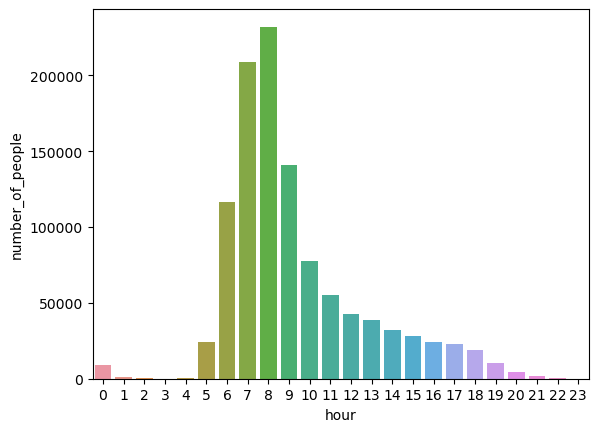

In [43]:
sns.barplot(x = df_tmp["hour"], y = df_tmp["number_of_people"])

То же самое делаем для дней:

In [44]:
df_tmp2 = df["pass_dttm"].dt.weekday
df_tmp2 = df_tmp2.value_counts()
df_tmp2 = df_tmp2.reset_index().rename(columns = {'index': 'day', 'pass_dttm': 'number_of_people'})
df_tmp2

,day,number_of_people
0,0,169081
1,1,169068
2,2,168584
3,3,166645
4,4,160868
5,5,136813
6,6,119962


<AxesSubplot:xlabel='day', ylabel='number_of_people'>

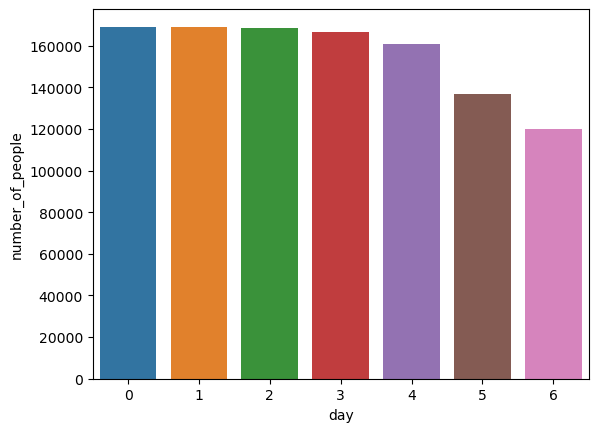

In [45]:
sns.barplot(x = df_tmp2["day"], y = df_tmp2["number_of_people"])

In [46]:
df.pass_dttm = pd.to_datetime(df.pass_dttm)
df['dayOfWeek'] = df.pass_dttm.dt.weekday
df['hour'] = df.pass_dttm.dt.hour
df.drop(['pass_dttm'], axis=1)

,ticket_id,ticket_type_nm,entrance_id,station_id,line_id,time_to_under,label,dayOfWeek,hour
0,40BD89EC85646EFB69E283F39C298E60,moneyPass,2402,11007,11,216.316667,8001,0,5
1,126727A96489CC976A8C08E5CEB00542,studentPass,110,2006,2,648.183333,9011,0,5
2,D28CE6A9E0E5B6D213470A97CFF32485,socialPass,110,2006,2,865.333333,7022,0,5
3,015DA44B523C062B5BFEFF3FB0E64B9E,justPass,110,2006,2,1048.233333,2022,0,5
4,95B19C6F3A504727AC3EA56EB7E3E80F,moneyPass,110,2006,2,965.600000,2017,0,5
...,...,...,...,...,...,...,...,...,...
1091016,6A738232F8E43DFCD4027FDC0EA6CC03,moneyPass,2283,15005,15,124.750000,15005,0,2
1091017,141174B366F14A8703903813A49374DB,moneyPass,278,6007,6,56.066667,6007,0,3
1091018,E38493B30A7C55170806F187AF5EEA15,moneyPass,118,2010,2,91.283333,2010,0,3
1091019,3DF2B6366631ECA06274DD2CB5B0DF24,moneyPass,2452,11014,11,47.900000,11014,0,3


In [47]:
rushHour = [5, 6, 7, 8, 9, 10]
df['isRushHour'] = False
df['isRushHour'].mask(df.hour.isin(rushHour), True, inplace=True)

weekend = [5, 6]
df['isWeekend'] = False
df['isWeekend'].mask(df.dayOfWeek.isin(weekend), True, inplace=True)

df = df.drop(['pass_dttm'], axis=1)


In [48]:
df

,ticket_id,ticket_type_nm,entrance_id,station_id,line_id,time_to_under,label,dayOfWeek,hour,isRushHour,isWeekend
0,40BD89EC85646EFB69E283F39C298E60,moneyPass,2402,11007,11,216.316667,8001,0,5,True,False
1,126727A96489CC976A8C08E5CEB00542,studentPass,110,2006,2,648.183333,9011,0,5,True,False
2,D28CE6A9E0E5B6D213470A97CFF32485,socialPass,110,2006,2,865.333333,7022,0,5,True,False
3,015DA44B523C062B5BFEFF3FB0E64B9E,justPass,110,2006,2,1048.233333,2022,0,5,True,False
4,95B19C6F3A504727AC3EA56EB7E3E80F,moneyPass,110,2006,2,965.600000,2017,0,5,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1091016,6A738232F8E43DFCD4027FDC0EA6CC03,moneyPass,2283,15005,15,124.750000,15005,0,2,False,False
1091017,141174B366F14A8703903813A49374DB,moneyPass,278,6007,6,56.066667,6007,0,3,False,False
1091018,E38493B30A7C55170806F187AF5EEA15,moneyPass,118,2010,2,91.283333,2010,0,3,False,False
1091019,3DF2B6366631ECA06274DD2CB5B0DF24,moneyPass,2452,11014,11,47.900000,11014,0,3,False,False


In [49]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()

In [50]:
data_ttype = onehotencoder.fit_transform(df[['ticket_type_nm']])
data_ttype = pd.DataFrame(data_ttype.toarray(), columns=onehotencoder.categories_[0])

In [51]:
data_new = pd.concat([df, data_ttype], axis=1)
data_new = data_new.drop('ticket_type_nm', axis=1)
data_new

,ticket_id,entrance_id,station_id,line_id,time_to_under,label,dayOfWeek,hour,isRushHour,isWeekend,justPass,moneyPass,socialPass,studentPass,suburbanPass,subwayWorkerPass
0,40BD89EC85646EFB69E283F39C298E60,2402,11007,11,216.316667,8001,0,5,True,False,0.0,1.0,0.0,0.0,0.0,0.0
1,126727A96489CC976A8C08E5CEB00542,110,2006,2,648.183333,9011,0,5,True,False,0.0,0.0,0.0,1.0,0.0,0.0
2,D28CE6A9E0E5B6D213470A97CFF32485,110,2006,2,865.333333,7022,0,5,True,False,0.0,0.0,1.0,0.0,0.0,0.0
3,015DA44B523C062B5BFEFF3FB0E64B9E,110,2006,2,1048.233333,2022,0,5,True,False,1.0,0.0,0.0,0.0,0.0,0.0
4,95B19C6F3A504727AC3EA56EB7E3E80F,110,2006,2,965.600000,2017,0,5,True,False,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091016,6A738232F8E43DFCD4027FDC0EA6CC03,2283,15005,15,124.750000,15005,0,2,False,False,0.0,1.0,0.0,0.0,0.0,0.0
1091017,141174B366F14A8703903813A49374DB,278,6007,6,56.066667,6007,0,3,False,False,0.0,1.0,0.0,0.0,0.0,0.0
1091018,E38493B30A7C55170806F187AF5EEA15,118,2010,2,91.283333,2010,0,3,False,False,0.0,1.0,0.0,0.0,0.0,0.0
1091019,3DF2B6366631ECA06274DD2CB5B0DF24,2452,11014,11,47.900000,11014,0,3,False,False,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
col_type = data_new.columns.to_list()
print(col_type)

['ticket_id', 'entrance_id', 'station_id', 'line_id', 'time_to_under', 'label', 'dayOfWeek', 'hour', 'isRushHour', 'isWeekend', 'justPass', 'moneyPass', 'socialPass', 'studentPass', 'suburbanPass', 'subwayWorkerPass']


In [53]:
columns_set_1 = ['entrance_id', 'station_id', 'line_id', 'dayOfWeek', 'hour', 'isRushHour',
                 'isWeekend', 'justPass', 'moneyPass', 'socialPass', 'studentPass', 'suburbanPass', 'subwayWorkerPass']

МОДЕЛЬ

In [54]:
X = data_new[columns_set_1]
Y = y = data_new['time_to_under']

In [55]:
x_regress_train, x_regress_test, y_regress_train, y_regress_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Рандомный лес:

In [56]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(x_regress_train, y_regress_train)

RandomForestRegressor()

In [57]:
y_pred_rf = rf.predict(x_regress_test)
r2_score(y_regress_test, y_pred_rf)

0.4652112730334734

XGBoost

In [58]:
import xgboost as xgb

In [59]:
model_xgb = xgb.XGBRegressor()
model_xgb.fit(x_regress_train, y_regress_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [60]:
y_pred_xgb = model_xgb.predict(x_regress_test)
r2_score(y_regress_test, y_pred_xgb)

0.5252190397840011

CatBoost

In [61]:
cat = CatBoostRegressor()
cat.fit(x_regress_train, y_regress_train)

Learning rate set to 0.119356
0:	learn: 219.6008385	total: 210ms	remaining: 3m 30s
1:	learn: 208.7172774	total: 279ms	remaining: 2m 19s
2:	learn: 199.8722770	total: 348ms	remaining: 1m 55s
3:	learn: 192.5221896	total: 429ms	remaining: 1m 46s
4:	learn: 186.6445160	total: 502ms	remaining: 1m 39s
5:	learn: 181.8430424	total: 574ms	remaining: 1m 35s
6:	learn: 178.0284052	total: 645ms	remaining: 1m 31s
7:	learn: 174.9730053	total: 722ms	remaining: 1m 29s
8:	learn: 172.4532015	total: 804ms	remaining: 1m 28s
9:	learn: 170.4195828	total: 902ms	remaining: 1m 29s
10:	learn: 168.8174360	total: 1.05s	remaining: 1m 34s
11:	learn: 167.5055494	total: 1.21s	remaining: 1m 39s
12:	learn: 166.4830043	total: 1.32s	remaining: 1m 40s
13:	learn: 165.6274947	total: 1.42s	remaining: 1m 39s
14:	learn: 164.9589054	total: 1.5s	remaining: 1m 38s
15:	learn: 164.4001452	total: 1.58s	remaining: 1m 37s
16:	learn: 163.9170670	total: 1.7s	remaining: 1m 38s
17:	learn: 163.5479862	total: 1.8s	remaining: 1m 38s
18:	learn: 

In [62]:
y_pred_cat = cat.predict(x_regress_test)
r2_score(y_regress_test, y_pred_cat)

0.5253062910238631

Линейная регрессия

In [64]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(x_regress_train, y_regress_train)

LinearRegression()

In [65]:
y_pred_lr = model_lr.predict(x_regress_test)
r2_score(y_regress_test, y_pred_lr)

0.49760994527356106